In [1]:
using Revise, DataFrames, NIRBeer, JDF, Arrow, CSV, Plots, FiniteDifferences, ForwardDiff

In [2]:
df_dsa = DataFrame(loadjdf("data/Beer_Analyzer_Data_clean.jdf"))
df_nir = DataFrame(Arrow.Table("data/Fermentation_NIR_absorbance_full.feather"));

In [70]:
min_time = 0
max_time = 12
k_rate = 20
exponent = 3/2

# Get unique batch names
batch_names = disallowmissing(unique(df_nir.BatchName))
idx_selected = []
for batch in batch_names
    itp = pchip_interpolation(df_dsa, batch, :extract)
    last_sample = last(df_dsa[df_dsa.BatchName .== batch, :CumulativeTime])
    cumulative_time = df_nir[df_nir.BatchName .== batch, :CumulativeTime]
    cumulative_time = cumulative_time[cumulative_time .<= last_sample]

    
    last_time = -Inf

    for (i, t) in enumerate(cumulative_time)
        dE = abs(ForwardDiff.derivative(itp, t))

        dt_local =  max_time * exp(-k_rate * dE)^exponent
        dt_local = max(dt_local, min_time)

        if t >= last_time + dt_local
            push!(idx_selected, i)
            last_time = t
        end
       
    end
    println("Batch: $batch, selected points: $(length(idx_selected))")
    break
end

Batch: 01_Zwickelbier, selected points: 68


Last sample time for batch 01_Zwickelbier: 325.6666667 h


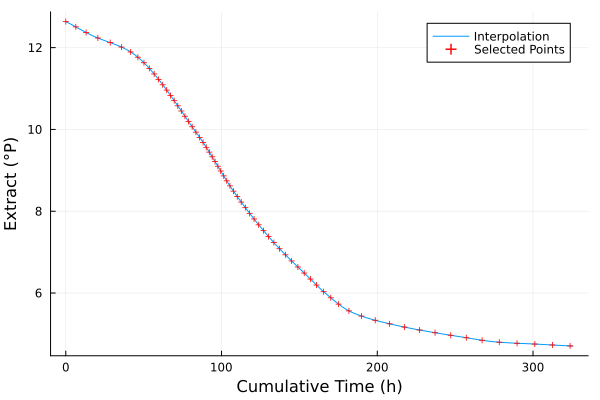

In [71]:
batch = "01_Zwickelbier"

last_sample = last(df_dsa[df_dsa.BatchName .== batch, :CumulativeTime])
println("Last sample time for batch $batch: $last_sample h")

itp = pchip_interpolation(df_dsa, batch, :extract)
ts = df_nir[df_nir.BatchName .== batch, :CumulativeTime]
ts_selected = ts[ts .<= last_sample]
ys = itp.(ts_selected)

scatter_idx = 1:length(ts_selected)

plot(ts_selected, ys, label="Interpolation", xlabel="Cumulative Time (h)", ylabel="Extract (°P)")
scatter!(ts_selected[idx_selected], ys[idx_selected], label="Selected Points", color=:red, markershape=:cross, markersize=3)